# Proyek Klasifikasi Gambar: Apparel Image Dataset
- **Nama:** Salsabila Mahiroh
- **Email:** Salsabilammm777@gmail.com
- **ID Dicoding:** salsabilammm

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import shutil
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras.layers import TFSMLayer

## Data Preparation

### Data Loading

In [2]:
# upload fie json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salsabilamahiroh","key":"83f2c616a0acffeee5c38d0142429ba0"}'}

In [3]:
# unduh dan load dataset apparel
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d trolukovich/apparel-images-dataset

import zipfile
with zipfile.ZipFile("apparel-images-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("apparel_dataset")

Dataset URL: https://www.kaggle.com/datasets/trolukovich/apparel-images-dataset
License(s): CC0-1.0


In [4]:
# melihat jumlah citra dan ukuran resolusi
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

# Memanggil fungsi direktori path 'apparel_dataset'
print_images_resolution("apparel_dataset")

Output streaming akan dipotong hingga 5000 baris terakhir.
- (260, 280)
- (474, 389)
- (426, 578)
- (350, 210)
- (474, 654)
- (312, 592)
- (280, 380)
- (288, 500)
- (340, 510)
- (474, 510)
- (413, 500)
- (474, 1184)
- (225, 300)
- (405, 267)
- (474, 775)
- (433, 594)
- (224, 600)
- (474, 366)
- (474, 631)
- (474, 896)
- (443, 500)
- (300, 451)
- (474, 487)
- (300, 222)
- (474, 1161)
- (474, 752)
- (474, 343)
- (191, 400)
- (444, 500)
- (256, 300)
- (474, 608)
- (474, 379)
- (426, 568)
- (474, 644)
- (466, 640)
- (300, 199)
- (474, 729)
- (340, 500)
- (474, 500)
- (286, 300)
- (430, 430)
- (474, 765)
- (160, 160)
- (400, 407)
- (474, 356)
- (474, 621)
- (160, 281)
- (474, 477)
- (474, 742)
- (300, 297)
- (474, 333)
- (258, 300)
- (460, 1338)
- (461, 659)
- (474, 598)
- (385, 520)
- (391, 600)
- (209, 300)
- (474, 454)
- (474, 719)
- (474, 310)
- (474, 984)
- (474, 575)
- (326, 448)
- (474, 346)
- (474, 840)
- (426, 800)
- (474, 696)
- (474, 467)
- (240, 300)
- (474, 961)
- (474, 732)
- 

**Catatan :**

- Dataset yang di gunakan adalah Apparel Image Dataset, yang memiliki total 11385 gambar, dengan jumlah 24 kelas di dalamnya
- Masing-masing gambar dalam dataset ini memiliki resolusi yang bervariasi atau beragam

### Data Preprocessing

#### Split Dataset

In [5]:
# Cek isi folder dataset
base_dir = "apparel_dataset"
categories = os.listdir(base_dir)
print("Label kategori:", categories)

Label kategori: ['brown_shoes', 'red_pants', 'white_pants', 'red_shoes', 'black_shorts', 'black_dress', 'red_dress', 'black_shoes', 'white_dress', 'green_shirt', 'green_shoes', 'blue_shirt', 'green_shorts', 'green_pants', 'blue_shorts', 'white_shoes', 'brown_shorts', 'blue_dress', 'brown_pants', 'black_shirt', 'black_pants', 'blue_pants', 'blue_shoes', 'white_shorts']


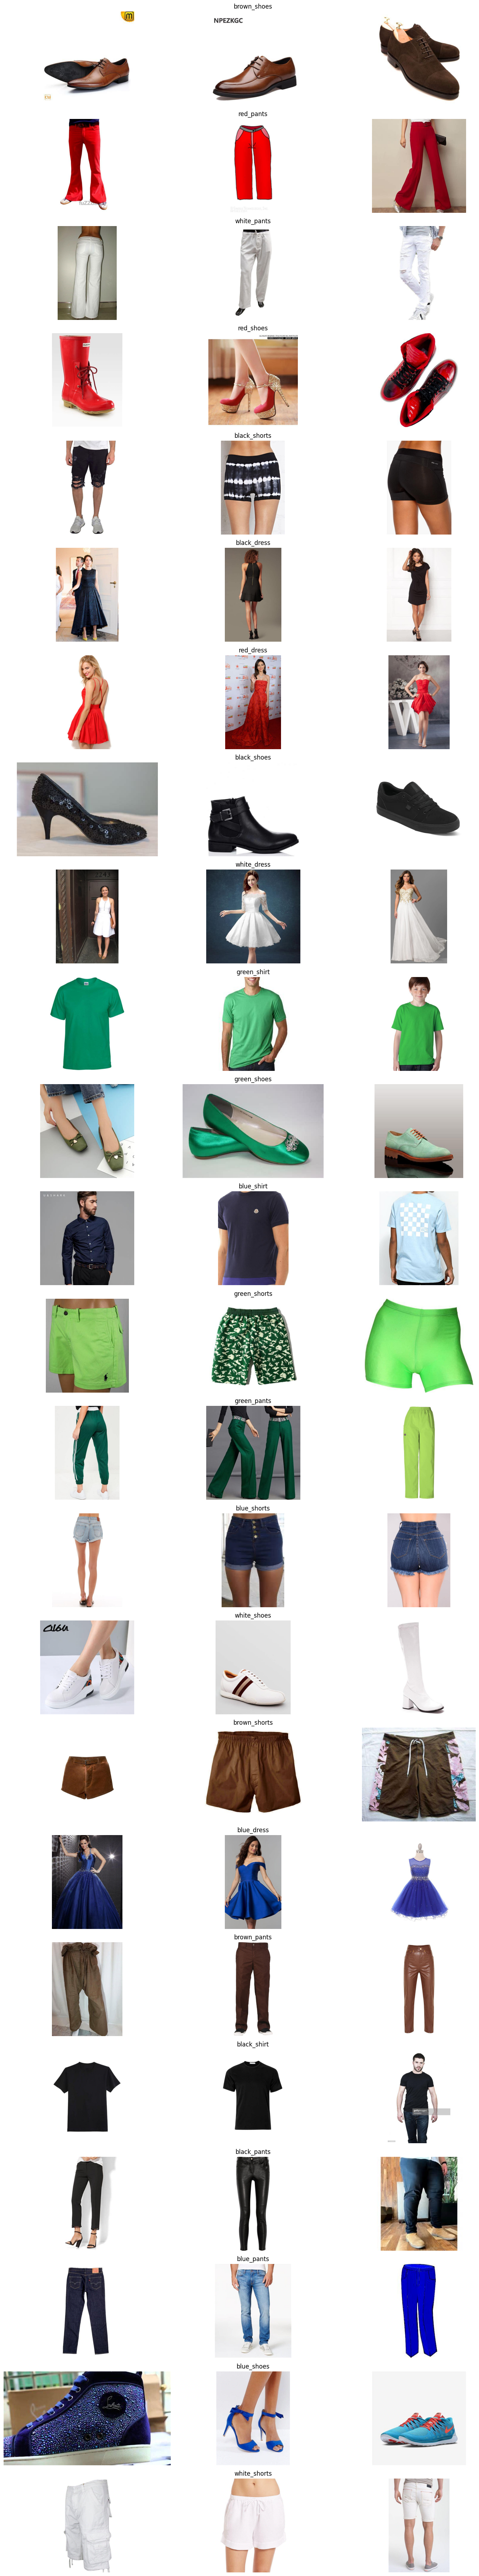

In [6]:
# melihat 3 gambar acak
# Set jumlah contoh per kelas
samples_per_class = 3

# Ukuran figure
plt.figure(figsize=(15, len(categories) * 3))

# Loop setiap kelas
for i, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)

    # Ambil 3 gambar acak dari kelas tersebut
    selected_images = random.sample(images, samples_per_class)

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(category_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(categories), samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:
            plt.title(category, fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
# Membuat folder untuk split data menjadi train, test, dan val
os.makedirs('apparel_split/train', exist_ok=True)
os.makedirs('apparel_split/val', exist_ok=True)
os.makedirs('apparel_split/test', exist_ok=True)

for category in categories:
    images = os.listdir(os.path.join(base_dir, category))
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    for phase, image_list in zip(['train', 'val', 'test'],
                                 [images[:train_split], images[train_split:val_split], images[val_split:]]):
        dest_dir = f'apparel_split/{phase}/{category}'
        os.makedirs(dest_dir, exist_ok=True)
        for img in image_list:
            src = os.path.join(base_dir, category, img)
            dst = os.path.join(dest_dir, img)
            shutil.copyfile(src, dst)

In [8]:
base_dir = 'apparel_dataset/apparel_images'
img_size = 128
batch_size = 32

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'apparel_split/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'apparel_split/val',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'apparel_split/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7960 images belonging to 24 classes.
Found 2278 images belonging to 24 classes.
Found 1147 images belonging to 24 classes.


**Catatan :**
- Dataset di bagi menjadi data training, data testing, dan data validasi dengan porsi :

**Training set:** 70%, **Validation set:** 20%, dan **Testing set:** 10%

## Modelling

In [9]:
# pemodelan dengan model sequential, conv2d, dan pooling layer
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,951,128 (49.40 MB)

 Trainable params: 12,951,128 (49.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 60s 219ms/step - accuracy: 0.3992 - loss: 2.1088 - val_accuracy: 0.7752 - val_loss: 0.7192
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 71s 192ms/step - accuracy: 0.7128 - loss: 0.8842 - val_accuracy: 0.7985 - val_loss: 0.6237
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step - accuracy: 0.7668 - loss: 0.7149 - val_accuracy: 0.8253 - val_loss: 0.5452
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.8082 - loss: 0.6058 - val_accuracy: 0.8543 - val_loss: 0.4472
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.8174 - loss: 0.5666 - val_accuracy: 0.8736 - val_loss: 0.4044
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.8318 - loss: 0.5222 - val_accuracy: 0.8758 - val_loss: 0.3857
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.8482 - loss: 0.4676 - val_accuracy: 0.8727 - val_loss: 0.3927
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step - accuracy: 0.8535 - loss: 0

## Evaluasi dan Visualisasi

In [15]:
# Setelah training selesai, dan load model terbaik dari .keras
model = tf.keras.models.load_model('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9257 - loss: 0.2354
Test Loss: 0.28499460220336914
Test Accuracy: 0.9145597219467163


In [14]:
# Mengambil riwayat akurasi train dari objek history
train_accuracy = history.history['accuracy']

# Menampilkan akurasi train
print(f"Akurasi Train: {train_accuracy[-1] * 100:.2f}%")

Akurasi Train: 91.61%


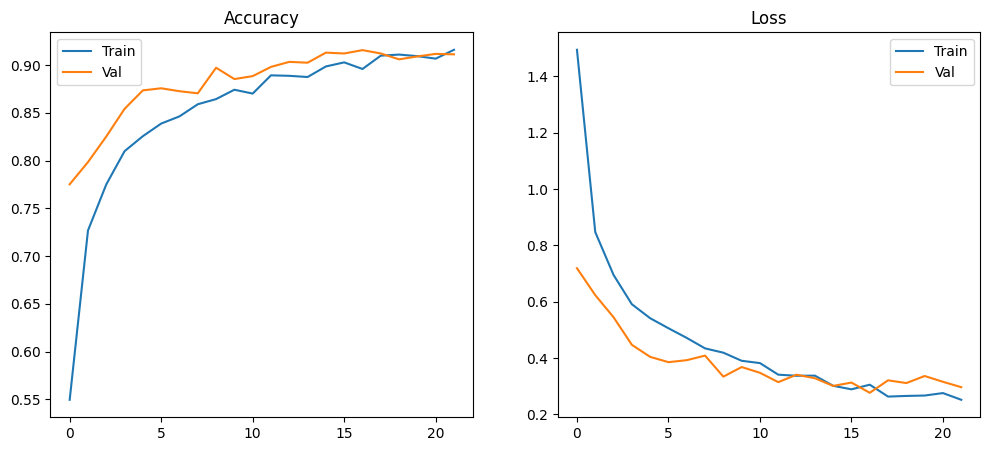

In [16]:
# membuat dan melihat plot akurasi dan loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.show()

## Konversi Model

In [17]:
# menyimpan ke format save model
model.export('saved_model/apparel_model')

Saved artifact at 'saved_model/apparel_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  135249217930832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217934480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217935824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217936592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217934672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217937360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217937168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217938704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217938128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135249217939472: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [18]:
# Simpan label ke file label.txt
labels = list(train_generator.class_indices.keys())
with open("label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

# Konversi model ke format TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/apparel_model")
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke TensorFlow Lite.")


✅ Model berhasil dikonversi ke TensorFlow Lite.


In [19]:
# Instal TensorFlow.js
!pip install tensorflowjs

# Buat folder untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Konversi model dari SavedModel ke TFJS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model/apparel_model tfjs_model

# Print pesan berhasil
print("✅ Model berhasil dikonversi ke TensorFlow.js.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-21 01:07:26.386162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745197646.417093    7272 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

## Inference (Optional)

**Inference dengan Save Model**

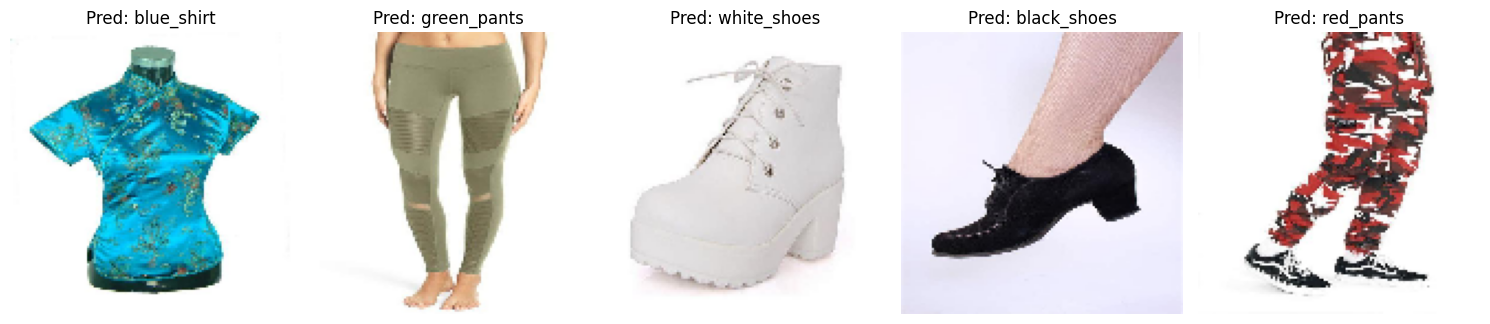

In [23]:
# Load model menggunakan TFSMLayer
model = TFSMLayer('saved_model/apparel_model', call_endpoint='serve')

# Load label
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Ambil 5 gambar acak dari test folder
test_folder = 'apparel_split/test'
all_classes = os.listdir(test_folder)
random_images = []

for _ in range(5):
    cls = random.choice(all_classes)
    img_file = random.choice(os.listdir(os.path.join(test_folder, cls)))
    img_path = os.path.join(test_folder, cls, img_file)
    random_images.append(img_path)

# Prediksi dan tampilkan
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(random_images):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model(img_array)
    pred_label = labels[np.argmax(pred)]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Inference dengan TfLite**

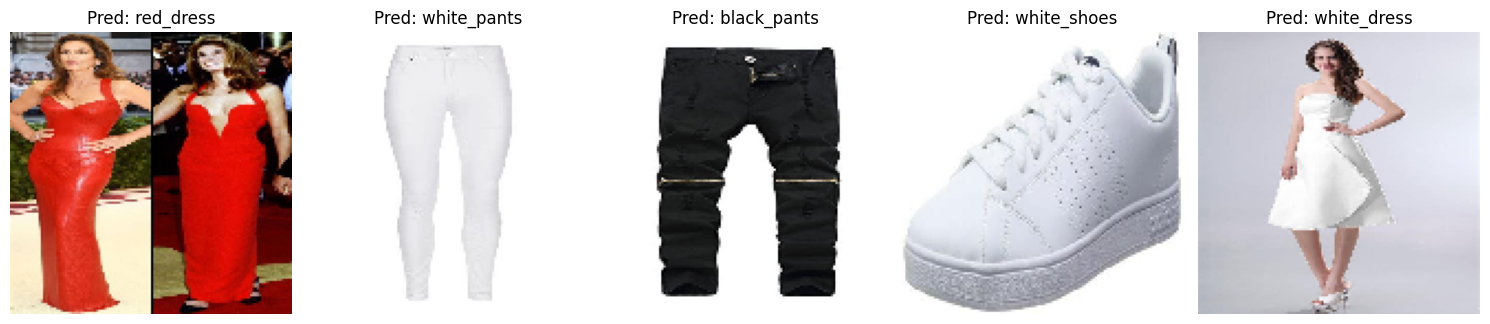

In [22]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Ambil 5 gambar acak dari test folder
test_folder = 'apparel_split/test'
all_classes = os.listdir(test_folder)
random_images = []

for _ in range(5):
    cls = random.choice(all_classes)
    img_file = random.choice(os.listdir(os.path.join(test_folder, cls)))
    img_path = os.path.join(test_folder, cls, img_file)
    random_images.append(img_path)

# Prediksi dan tampilkan
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(random_images):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    pred_label = labels[np.argmax(output)]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()